Arquivo original: DimEstWav.m

In [4]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pywt
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# DimEstWav/DimEst_boot.m
def DimEst_boot(Y, NREP, B, p, N, wname):
    """
    Python translation of MATLAB DimEst_boot.

    Parameters
    ----------
    Y : array (nt x n)
        Functional observations
    NREP : int
        Number of bootstrap replications
    B : array (J x d0)
        Eigenvector matrix (wavelet coefficients of estimated eigenfunctions)
    p : int
        Maximum lag
    N : int
        Wavelet decomposition level
    wname : str
        Wavelet name (e.g. 'db2')

    Returns
    -------
    vd0p1_boot : array (NREP,)
        Bootstrap estimates of eigenvalue_{d0+1}
    """

    J, d0 = B.shape
    nt, n = Y.shape

    vd0p1_boot = np.zeros(NREP)
    Yhat = np.zeros((nt, n))
    H = np.zeros((nt, d0))
    A = np.zeros((J, n))
    Yboot = np.zeros((nt, n))
    Aboot = np.zeros((J, n))

    # =====================================================================
    # Compute wavelet decomposition of Y
    # =====================================================================
    # Get coefficient slicing lengths using first column
    coeffs0 = pywt.wavedec(Y[:, 0], wname, level=N)
    lengths = [len(c) for c in coeffs0]

    for ii in range(n):
        coeffs = pywt.wavedec(Y[:, ii], wname, level=N)
        A[:, ii] = np.concatenate(coeffs)

    mu_A = A.mean(axis=1, keepdims=True)
    C = A - mu_A

    # =====================================================================
    # Reconstruct mean function using inverse wavelet transform
    # =====================================================================
    def waverec_from_vector(v):
        out = []
        idx = 0
        for L in lengths:
            out.append(v[idx:idx+L])
            idx += L
        return pywt.waverec(out, wname)

    mu_hat = waverec_from_vector(mu_A[:, 0])

    # =====================================================================
    # Reconstruct eigenfunctions H(:,k)
    # =====================================================================
    for ii in range(d0):
        H[:, ii] = waverec_from_vector(B[:, ii])

    # =====================================================================
    # Compute fitted curves Yhat
    # =====================================================================
    for ii in range(n):
        Yhat[:, ii] = mu_hat.copy()
        for k in range(d0):
            coef = C[:, ii].T @ B[:, k]   # inner product
            Yhat[:, ii] += coef * H[:, k]

    mEps_hat = Y - Yhat

    # =====================================================================
    # Bootstrap replications
    # =====================================================================
    for jj in range(NREP):

        # Resample residual curves with replacement
        for ii in range(n):
            idx = np.random.randint(0, n)
            Yboot[:, ii] = Yhat[:, ii] + mEps_hat[:, idx]

            coeffs = pywt.wavedec(Yboot[:, ii], wname, level=N)
            Aboot[:, ii] = np.concatenate(coeffs)

        mu_Aboot = Aboot.mean(axis=1, keepdims=True)
        Cb = Aboot - mu_Aboot

        C1 = Cb[:, :n-p]
        D1 = np.zeros((n-p, n-p))

        for k in range(1, p+1):
            Ct = Cb[:, k:(n-p+k)]
            D1 += Ct.T @ Ct

        Dboot = C1 @ D1 @ C1.T / ((n - p)**2)

        # eigen-decomposition
        Lboot, Bboot = np.linalg.eig(Dboot)

        # MATLAB takes Lboot(d0+1,d0+1), but eigenvalues are unordered.
        # We sort them descending to match MATLAB's behavior.
        L_sorted = np.sort(Lboot)[::-1]

        vd0p1_boot[jj] = L_sorted[d0]

    return vd0p1_boot

In [6]:

# ==========================================================
# PARAMETERS
# ==========================================================
n = 100          # sample size
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

# ==========================================================
# ARIMA PROCESSES FOR UNOBSERVED FUNCTIONAL DYNAMICS
# ==========================================================
# model_xi1 = ARIMA([0], order=(1, 0, 0), trend="n").fit(start_params=[-0.65])
# model_xi2 = ARIMA([0], order=(1, 0, 0), trend="n").fit(start_params=[0.40])

# xi1 = model_xi1.simulate(nsimulations=n)
# xi2 = model_xi2.simulate(nsimulations=n)

def simulate_ar1(phi, n, sigma2=1.5):
    x = np.zeros(n)
    eps = np.random.normal(scale=np.sqrt(sigma2), size=n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + eps[t]
    return x

# simulate processes
xi1 = simulate_ar1(-0.65, n)
xi2 = simulate_ar1( 0.40, n)

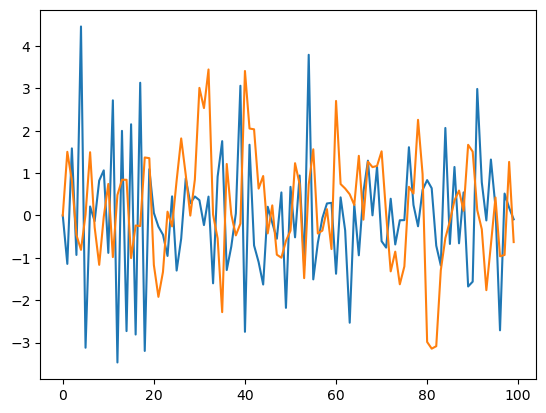

In [7]:
plt.figure()

plt.plot(xi1)
plt.plot(xi2)

plt.show()

In [8]:

# ==========================================================
# GENERATE UNOBSERVED FUNCTIONAL DATA X(t)
# ==========================================================
X = np.zeros((nt, n))

for ii in range(n):
    X[:, ii] = (
        xi1[ii] * np.sqrt(2) * np.cos(np.pi * u[:, 0]) +
        xi2[ii] * np.sqrt(2) * np.cos(2 * np.pi * u[:, 0])
    )

In [9]:

# ==========================================================
# ADD NOISE USING SINE SERIES
# ==========================================================
mEps = np.zeros((nt, n))

for ii in range(n):
    for jj in range(1, 11):
        mEps[:, ii] += (
            norm.rvs(scale=1.0) * np.sqrt(2) *
            np.sin(np.pi * u[:, 0] * jj) / (2 ** (jj - 1))
        )

In [10]:

# ==========================================================
# OBSERVED FUNCTIONAL DATA
# ==========================================================
Y = X + mEps

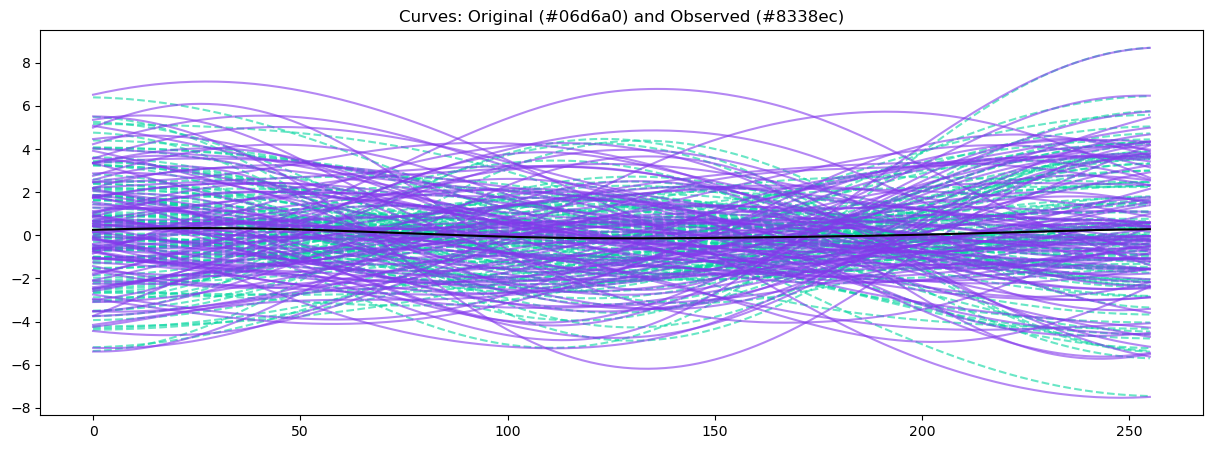

In [28]:
plt.figure(figsize=(15,5))


color_original = "#06d6a0"
plt.plot(X, alpha=.6, c=color_original, linestyle="--",label="Unobserved")

color_observed = "#8338ec"
plt.plot(Y, alpha=.6, c=color_observed, label="Observed")

plt.plot(np.mean(Y,axis=1), c="black")

plt.title(f"Curves: Original ({color_original}) and Observed ({color_observed})")

plt.show()

In [29]:

# ==========================================================
# WAVELET DECOMPOSITION
# ==========================================================
wavelet = "db2"
J = 263  # MATLAB-specific number of coefficients
A = np.zeros((J, n))

dec_example = pywt.wavedec(Y[:, 0], wavelet, level=N)
# compute slicing index to reconstruct full coefficient vector
lengths = [len(c) for c in dec_example]
cum_len = np.sum(lengths)

for ii in range(n):
    coeffs = pywt.wavedec(Y[:, ii], wavelet, level=N)
    A[:, ii] = np.concatenate(coeffs)

mu_A = A.mean(axis=1, keepdims=True)
C = A - mu_A

In [31]:

# ==========================================================
# BUILD MATRIX D
# ==========================================================
p = 5
C1 = C[:, :n-p]
D1 = np.zeros((n-p, n-p))

for k in range(1, p+1):
    Ct = C[:, k:(n-p+k)]
    D1 += Ct.T @ Ct

D = C1 @ D1 @ C1.T / ((n - p)**2)

In [32]:

# ==========================================================
# EIGEN-DECOMPOSITION
# ==========================================================
L, B = np.linalg.eig(D)

# sort eigenvalues descending
idx = np.argsort(-L)
L = L[idx]
B = B[:, idx]

print(L[:10])

print(np.linalg.norm(L[:4], 1) / np.linalg.norm(L, 1))

[2.06546518e+05+0.j 7.51109167e+04+0.j 2.01485132e+04+0.j
 1.62754155e+03+0.j 2.35465320e+02+0.j 1.35042276e+02+0.j
 4.72447903e+01+0.j 5.09079536e+00+0.j 3.61298644e+00+0.j
 5.93577922e-01+0.j]
0.9985943278962771


In [33]:

# ==========================================================
# WAVELET RECONSTRUCTION OF MEAN FUNCTION
# ==========================================================
# reconstruct mean using stored lengths
def reconstruct(coeff_vector, lengths):
    coeffs = []
    offset = 0
    for Lg in lengths:
        coeffs.append(coeff_vector[offset:offset+Lg])
        offset += Lg
    return pywt.waverec(coeffs, wavelet)

mu_hat = reconstruct(mu_A[:, 0], lengths)

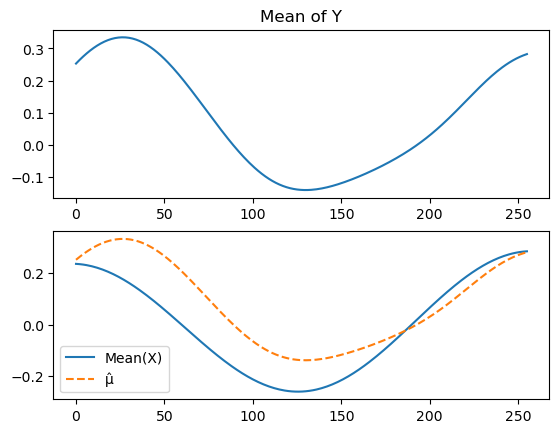

In [35]:
plt.subplot(2,1,1)
plt.plot(Y.mean(axis=1))
plt.title("Mean of Y")

plt.subplot(2,1,2)
plt.plot(X.mean(axis=1), label="Mean(X)")
plt.plot(mu_hat, label="μ̂", linestyle='--')
plt.legend()
plt.show()

In [37]:
NREP = 100
alpha = 0.1
d0 = 2
wname = 'db2'

d_boot = DimEst_boot(Y, NREP, B[:, :d0], p, N, wname)

print("Bootstrap p-value:", np.mean(d_boot > L[d0]))
print("Reject?", np.mean(d_boot > L[d0]) <= alpha)

C:\Users\mathe\AppData\Local\Temp\ipykernel_18180\4217732593.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, ii] = waverec_from_vector(B[:, ii])


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'